# COMP 9444 Final Project
## Toxic text Classification
### In this notebook, we will perform muticlass class classification on the dataset’s oroginal lables. We will decouple Feature Representation training and Classifier training into two steps.

In recent years, online hate or offensive comments have proliferated on social media platforms and online discussions. It only takes one toxic word in online forums and social platforms to sour an online discussion on the web. Toxic comments are harming all social platforms.

Thus it is essential to automatically detect and warn of toxic comments on social platforms and flag them for removal. In response, our project attempts to build two models to detect different toxicity types, each of which performs binary and multi-class classification. We first fine-tuned the pre-trained BERT model on the comments dataset from the Wikipedia discussion page editor. And then, we proposed a bi-direction LSTM model to approach the performance of our pre-trained Bert model. We observed that the pre-trained model is not better than the simple model in all metrics.

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sklearn
import os

Our data cleaning will replace nonsense symbols like ‘\n’ ‘\r’ and etc. with spaces.

We delete website URLs since this content is not related to our task.

We also want to replace a large string of repeating characters as one string.Without this data cleaning, the max length of comment text is 1411. After data cleaning, the max length will become 265.

Convert both data set to only have one label.
Drop rows in test set which has ‘-1’ value.

In [8]:
def data_cleaning(text):
    # 大小写
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace("#" , " ")
    text = text.replace("." , "")
    text = text.replace("%", "")



    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)
    text = re.sub('www.[A-Za-z0-9./]+', '', text)
    text = re.sub("\d+", "", text)
    text = re.sub("!+", "!", text)

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = text.strip(' ')

#     text = '!'.join(unique_list(text.split('!')))
    text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

Our data comes from: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

In this project, we adopt a real-world dataset: jigsaw-toxic- comment from Kaggle, which is a collection of Wikipedia comments labelled manually for toxic behaviour 1. The toxic labels are in 6 categories which are toxic, severe toxic, obscene, threat, insult and identity hate.
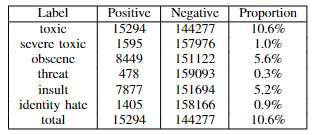

In [3]:
data_folder_path = './data/'
df = pd.read_csv(data_folder_path + 'train.csv')
test_text = pd.read_csv(data_folder_path + 'test.csv')
test_label = pd.read_csv(data_folder_path + 'test_labels.csv')
test_df = pd.concat([test_text, test_label], axis=1)
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [17]:
df['comment_text'] = df['comment_text'].apply(data_cleaning)
test_df['comment_text'] = test_df['comment_text'].apply(data_cleaning)

In [18]:
toxic_df = df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)]
non_toxic_df = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)]
df_o = df.copy()

In [19]:
ids_to_drop = []
for i in range(len(test_df)):
    if test_df['toxic'][i] == -1 or test_df['severe_toxic'][i] == -1 or test_df['obscene'][i] == -1 or test_df['threat'][i] == -1 or test_df['insult'][i] == -1 or test_df['identity_hate'][i] == -1:
        ids_to_drop.append(i)

test_df = test_df.drop(ids_to_drop)
test_df.head()

,id,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding I think very highl...,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,Dear god this site is horrible,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,Somebody will invariably try to add Religion R...,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,It says it even in Binghamton University Unive...,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,Before adding a new product to the list make s...,00059ace3e3e9a53,0,0,0,0,0,0


([<matplotlib.patches.Wedge at 0x7f10eac14220>,
 [Text(-1.0443548066304753, 0.3454316688837642, 'clean'),
  Text(1.0443548389721178, -0.34543157110420913, 'toxic')],
 [Text(-0.5696480763438956, 0.18841727393659866, '89.8%'),
  Text(0.5696480939847914, -0.18841722060229588, '10.2%')])

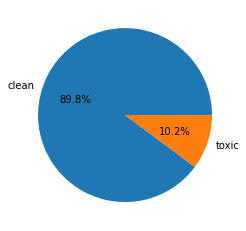

In [20]:
#percentage of clean comments
plt.pie([len(df['comment_text']) - len(toxic_df['comment_text']), len(toxic_df['comment_text'])], labels=['clean', 'toxic'], autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x7f10e6f45460>,
 [Text(0.2205229793508023, 1.0776686019265134, 'toxic'),
  Text(-1.0627685713534702, 0.28376568457673707, 'severe_toxic'),
  Text(-0.88354481837012, -0.655246941184247, 'obscene'),
  Text(-0.1465638198299719, -1.0901922063181555, 'threat'),
  Text(0.6339460365091164, -0.8989507343533251, 'insult'),
  Text(1.0913128295372536, -0.1379721279367442, 'identity_hate')],
 [Text(0.12028526146407398, 0.5878192374144617, '43.6%'),
  Text(-0.5796919480109837, 0.15478128249640202, '4.5%'),
  Text(-0.48193353729279265, -0.35740742246413465, '24.1%'),
  Text(-0.0799439017254392, -0.5946502943553574, '1.4%'),
  Text(0.3457887471867907, -0.49033676419272265, '22.4%'),
  Text(0.5952615433839564, -0.0752575243291332, '4.0%')])

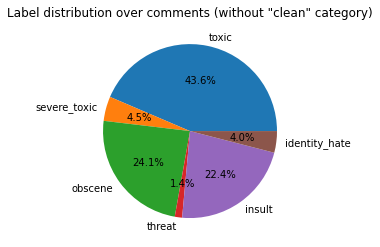

In [21]:
#percentages of each labels
plt.title('Label distribution over comments (without "clean" category)')
plt.pie([len(df[df['toxic'] == 1]), len(df[df['severe_toxic'] == 1]), len(df[df['obscene'] == 1]), len(df[df['threat'] == 1]), len(df[df['insult'] == 1]), len(df[df['identity_hate'] == 1])], labels=classes, autopct='%1.1f%%')

Such dominance of instance-rich (or head) classes throughout the training process is a typical problem when learning from the imbalanced dataset. The classification model often performs better on head classes, but its performance is noticeably poorer, for instance-scarce (or tail) classes. So we need find some approaches to enhance the classification performance of the tail classes, such as ‘severe_toxic’, ’ threat’ and ‘identity_hate’.

## Load pre-trained word vectors
For the LSTM model, we choose GloVe’s pre-trained word vectors trained on Twitter tweets with an output vector size of 200 as our word embedding as tweets have similar properties to our dataset.


In [11]:
from torchtext.vocab import GloVe, vocab
from torchtext.data.utils import get_tokenizer

unk_token = "<pad>"
unk_index = 0
#name = "vector_cache"


if os.path.isdir("./.vector_cache"):
    glove_vectors = GloVe(name = 'twitter.27B', cache = './.vector_cache', dim=200)
else:    
    glove_vectors = GloVe('twitter.27B', dim=200)
print(len(glove_vectors.stoi))
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>",unk_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
print(pretrained_embeddings.shape)


1193514
torch.Size([1193515, 200])


In [12]:
tokenizer = get_tokenizer("basic_english")


class MyDataset(Dataset):

    def __init__(self, dataframe, max_len=100, pad_token='<pad>'):
         self.X = dataframe['comment_text'].values
         self.Y = dataframe[classes].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token
         # self.unk_token = unk_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]

        diff = self.max_len - len(tokens)
        # print('diff',diff)
        if diff > 0:

            tokens = [self.pad_token] * diff + tokens
            # print('tokens',to
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result


In [24]:
MAX_LEN = 0
for a in range(0 , len(df)):
    f = df["comment_text"][a]
    length = len(f.split())
    if length > MAX_LEN:
        MAX_LEN = length
        
train_dataset = MyDataset(df, MAX_LEN)
test_dataset = MyDataset(test_df, MAX_LEN)

## Model for Text Classification
Long short term memory (LSTM) is an improved recurrent network architecture. Simple Recurrent Network (SRN) stores information close to the current input in a context layer. Compared with SRN, LSTM not only has hidden unit values to keep short-term state but also context unit values to keep long-term state with three gates.

Forget gate with current input and previously hidden unit value will help previous co-text unit value to keep important information and forget unimportant details. Update value is between -1 and 1, which is normalized from the information of new input, and then the input gate will determine what information will be stored in long-term context. This updated long-term context will involve in current hidden unit values with the output gate.

For our current text classification task, the predicted output is determined by both the previous input and the following input. In Bi-directional long short term memory (Bi-LSTM), one more LSTM layer with opposite directions will be added and connected to the same output. Therefore, it will keep information from the past and present with input flows in two directions and help to achieve better performance.


For the LSTM model, we choose GloVe’s pre-trained word vectors trained on Twitter tweets with an output vector size of
200 as our word embedding as tweets have similar properties to our dataset. After our data cleaning, we will pre-pad each
sequence to the maximum length of cleaned comments. We experimented with a wide range of hyper-parameters for better performance, 3 LSTM layers with 0.2 dropouts and 2 Linear layers before the output layer. Layer Normalization also will
be applied before each Linear layer.

In [26]:


class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = False):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=3, bidirectional=True, dropout=0.5)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        self.LN = nn.LayerNorm(hidden_size * 4)
        self.LN2 = nn.LayerNorm(hidden_size * 2)

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):
        #print('input', indices.shape)

        embedded = self.embedding(indices.T)
        # print('embedded', embedded.shape)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)

        encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)
        
        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.LN2(out)
        out = self.dropout(out)
        out = self.fc2(out)

        #print('output', out.shape)


        #out = self.sigmoid(out)
        #print('out', out)

        return out

In [28]:
from torch.utils.data import DataLoader


BATCH_SIZE = 350

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Traning and Showing results for each epoch
We used standard instance-based sampling techniques and
standard loss function with no weight in the initial phase to
train our LSTM model.

               precision    recall  f1-score   support

        toxic       0.75      0.32      0.44      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.82      0.28      0.41      3691
       threat       0.00      0.00      0.00       211
       insult       0.75      0.26      0.38      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.77      0.26      0.39     14498
    macro avg       0.39      0.14      0.21     14498
 weighted avg       0.70      0.26      0.38     14498
  samples avg       0.03      0.02      0.02     14498

Epoch: 0 Train_Loss: 0.1218787930709751 Train_Accuracy: 0.9668653011322021
Epoch: 0 Test_Loss: 0.09710928270481323 Test_Accuracy: 0.9692056179046631


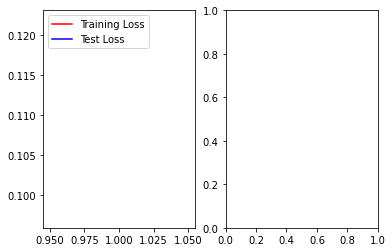

Epoch: 0 Time: 825.9824199676514
               precision    recall  f1-score   support

        toxic       0.74      0.42      0.54      6090
 severe_toxic       0.60      0.01      0.02       367
      obscene       0.80      0.43      0.56      3691
       threat       0.00      0.00      0.00       211
       insult       0.75      0.36      0.48      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.76      0.37      0.50     14498
    macro avg       0.48      0.20      0.27     14498
 weighted avg       0.71      0.37      0.48     14498
  samples avg       0.04      0.03      0.03     14498

Epoch: 1 Train_Loss: 0.07836981103837229 Train_Accuracy: 0.9749222993850708
Epoch: 1 Test_Loss: 0.08590308371218827 Test_Accuracy: 0.9717403054237366


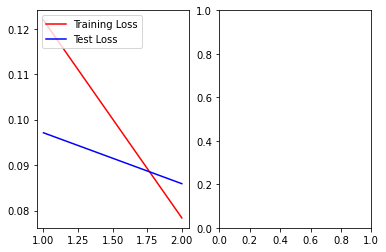

Epoch: 1 Time: 826.7759823799133


In [ ]:
from torch.optim import AdamW
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

#loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weight_set))
loss_fn = nn.BCEWithLogitsLoss()
model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=128)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")



loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

epochs = 50

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
accuracys = [ None for i in range(epochs)]
for e in range(epochs):
    start = time.time()
    model.train()
    epoch_loss = 0

    losses = []
    correct_predictions = 0
    for batch_id, batch in enumerate(train_dataloader):

        ids = batch['indices'].to(device)
        #print('ids: ', ids.shape)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        loss = loss_fn(outputs, labels)
        #print('loss: ', loss)

        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        # if batch_id % 100 == 0:
            # print('Epoch: {} Batch: {} Loss: {}'.format(e, batch_id, loss.item()))
            #print(loss.grad_fn)

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = correct_predictions/(len(df)*6)


    if e > 15:
        torch.save(model.state_dict(), '/mnt/f/bi-lstm_model_weight_set_epoch_{}.pt'.format(e))

    ## Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        predictions_store = []
        labels_store = []

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                predictions_store.append(preds[i])
                labels_store.append(labels[i])

        # print(pred_counter, label_counter)
        test_loss = np.mean(test_loss)
        accuracy = test_correct_predictions/(len(test_dataset)*6)
        test_losses[e] = test_loss

        rp = classification_report(labels_store, predictions_store, target_names=classes)
        print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, accuracy))

        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")

        plt.show()
        end = time.time()
        print('Epoch: {} Time: {}'.format(e, end-start))





Due to the time limitation, as the marking rubrix was released just one day before the due, we are not able to show you the training result with code in notebook. Here is the result we recorded from our previous training with exactly same code. 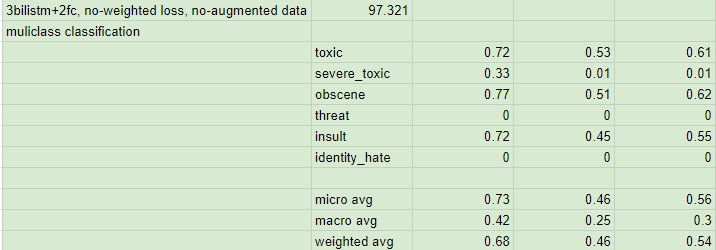

## Phase two training
Next, we freeze the LSTM layers and
only allow the downstream full-connection layers to update
their parameters. We use tail-classes enhanced data sampling
to re-train these classification layers with a lower learning rate,
carefully fine-tuning the decision boundaries for the model

In [5]:
#df_toxic = pd.read_csv(data_folder_path + 'toxic_balanced_sample.csv')
df_toxic = pd.read_csv('data/aug_samples_v4.csv')
# classes distribution
total_samples = df_toxic.shape[0]
for cls in classes:
    rate = df_toxic[cls].sum() / total_samples
    rate = np.round(rate*100, 3)
    print(cls +' rate: ', rate, "%")

toxic rate:  22.574 %
severe_toxic rate:  2.506 %
obscene rate:  14.447 %
threat rate:  5.387 %
insult rate:  13.951 %
identity_hate rate:  5.446 %


In [6]:
#drop no class samples
ids_to_drop = []
for r in range(len(df_toxic)):
    if df_toxic.iloc[r]['toxic'] == 0 and df_toxic.iloc[r]['severe_toxic'] == 0 and df_toxic.iloc[r]['obscene'] == 0 and df_toxic.iloc[r]['threat'] == 0 and df_toxic.iloc[r]['insult'] == 0 and df_toxic.iloc[r]['identity_hate'] == 0:
        ids_to_drop.append(r)
df_toxic = df_toxic.drop(ids_to_drop)
# drop only toxic comments
df_toxic.reset_index(drop=True, inplace=True)

ids_to_drop = []
for r in range(len(df_toxic)):
    if df_toxic['toxic'][r] == 1 and df_toxic['severe_toxic'][r] == 0 and df_toxic['threat'][r] == 0 and df_toxic['identity_hate'][r] == 0:
        ids_to_drop.append(r)
df_toxic= df_toxic.drop(ids_to_drop)
for cls in classes:
    rate = df_toxic[cls].sum() / len(df_toxic)
    rate = np.round(rate*100, 3)
    print(cls +' rate: ', rate, "%")
df_toxic.reset_index(drop=True, inplace=True)

toxic rate:  93.586 %
severe_toxic rate:  25.549 %
obscene rate:  71.725 %
threat rate:  54.923 %
insult rate:  75.21 %
identity_hate rate:  55.519 %


In [15]:
BATCH_SIZE = 350

In [16]:
df_toxic['comment_text'] = df_toxic['comment_text'].apply(data_cleaning)

In [17]:
train_dataset_2 = MyDataset(df_toxic)

In [21]:
train_dataloader_2 = DataLoader(train_dataset_2, batch_size=BATCH_SIZE, shuffle=True)

class TextClassificationModel2(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = True):
        super(TextClassificationModel2, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=3, bidirectional=True, dropout=0.5)
        for params in self.lstm.parameters():
            params.requires_grad = False
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)

        self.LN = nn.LayerNorm(hidden_size * 4)
        self.LN2 = nn.LayerNorm(hidden_size * 2)

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):
        #print('input', indices.shape)

        embedded = self.embedding(indices.T)
        # print('embedded', embedded.shape)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)

        encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)

        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.LN2(out)
        out = self.dropout(out)
        out = self.fc2(out)

        #print('output', out.shape)


        #out = self.sigmoid(out)
        #print('out', out)

        return out

We choose the best epoch model from phase 1

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TextClassificationModel2(pretrained_embeddings, len(classes), hidden_size=128).to(device)
model.load_state_dict(torch.load('//mnt/f/bi-lstm_model_weight_set_epoch_21.pt'))

<All keys matched successfully>

## Training and evaluation 

The table below collects the best result from our experiments
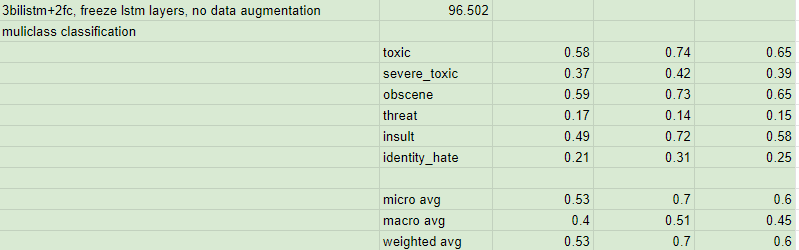

               precision    recall  f1-score   support

        toxic       0.65      0.59      0.62      6090
 severe_toxic       0.26      0.63      0.37       367
      obscene       0.67      0.59      0.63      3691
       threat       0.20      0.67      0.31       211
       insult       0.61      0.56      0.58      3427
identity_hate       0.26      0.48      0.33       712

    micro avg       0.57      0.58      0.57     14498
    macro avg       0.44      0.59      0.47     14498
 weighted avg       0.61      0.58      0.59     14498
  samples avg       0.05      0.05      0.04     14498

Epoch: 0 Train_Loss: 0.538341844623739 Train_Accuracy: 0.03371017798781395
Epoch: 0 Test_Loss: 0.09953448628304434 Test_Accuracy: 0.9672935009002686


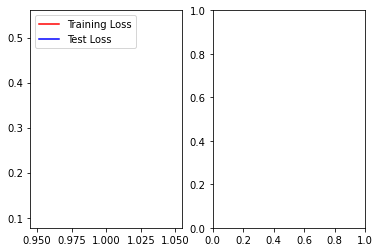

               precision    recall  f1-score   support

        toxic       0.65      0.60      0.62      6090
 severe_toxic       0.31      0.45      0.37       367
      obscene       0.68      0.59      0.63      3691
       threat       0.17      0.68      0.27       211
       insult       0.62      0.55      0.58      3427
identity_hate       0.25      0.50      0.33       712

    micro avg       0.57      0.57      0.57     14498
    macro avg       0.45      0.56      0.47     14498
 weighted avg       0.61      0.57      0.59     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 1 Train_Loss: 0.5154091620987112 Train_Accuracy: 0.033983826637268066
Epoch: 1 Test_Loss: 0.10053781688701911 Test_Accuracy: 0.9675644040107727


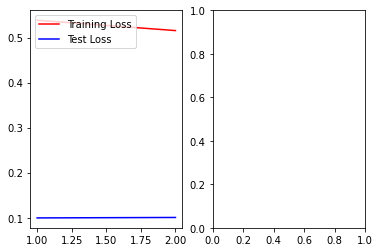

               precision    recall  f1-score   support

        toxic       0.64      0.60      0.62      6090
 severe_toxic       0.34      0.28      0.31       367
      obscene       0.69      0.58      0.63      3691
       threat       0.16      0.71      0.25       211
       insult       0.62      0.54      0.58      3427
identity_hate       0.23      0.50      0.31       712

    micro avg       0.57      0.57      0.57     14498
    macro avg       0.45      0.54      0.45     14498
 weighted avg       0.62      0.57      0.58     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 2 Train_Loss: 0.5045866600491784 Train_Accuracy: 0.034102894365787506
Epoch: 2 Test_Loss: 0.10330091701830671 Test_Accuracy: 0.9672074913978577


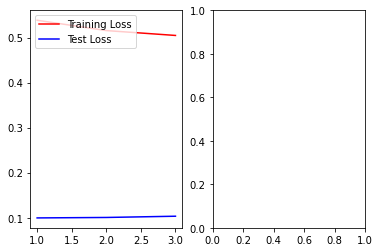

               precision    recall  f1-score   support

        toxic       0.64      0.60      0.62      6090
 severe_toxic       0.36      0.22      0.27       367
      obscene       0.69      0.58      0.63      3691
       threat       0.13      0.72      0.22       211
       insult       0.63      0.54      0.58      3427
identity_hate       0.20      0.47      0.28       712

    micro avg       0.55      0.57      0.56     14498
    macro avg       0.44      0.52      0.43     14498
 weighted avg       0.61      0.57      0.58     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 3 Train_Loss: 0.49031256952069024 Train_Accuracy: 0.03427001088857651
Epoch: 3 Test_Loss: 0.10805186665937548 Test_Accuracy: 0.9664233922958374


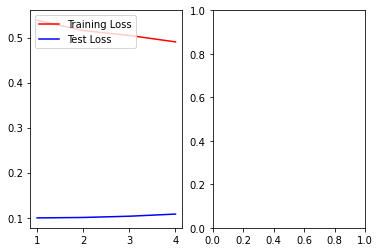

               precision    recall  f1-score   support

        toxic       0.63      0.61      0.62      6090
 severe_toxic       0.36      0.19      0.25       367
      obscene       0.69      0.58      0.63      3691
       threat       0.12      0.72      0.21       211
       insult       0.63      0.54      0.58      3427
identity_hate       0.17      0.48      0.25       712

    micro avg       0.54      0.57      0.55     14498
    macro avg       0.43      0.52      0.42     14498
 weighted avg       0.61      0.57      0.58     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 4 Train_Loss: 0.482866342772137 Train_Accuracy: 0.03435461223125458
Epoch: 4 Test_Loss: 0.11386508360260823 Test_Accuracy: 0.9653449058532715


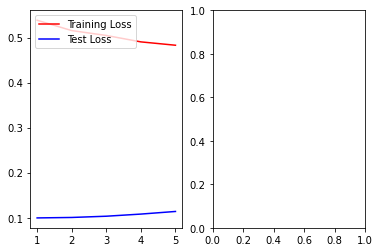

               precision    recall  f1-score   support

        toxic       0.63      0.61      0.62      6090
 severe_toxic       0.33      0.14      0.20       367
      obscene       0.69      0.58      0.63      3691
       threat       0.11      0.72      0.20       211
       insult       0.63      0.54      0.58      3427
identity_hate       0.15      0.47      0.22       712

    micro avg       0.53      0.57      0.55     14498
    macro avg       0.42      0.51      0.41     14498
 weighted avg       0.61      0.57      0.58     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 5 Train_Loss: 0.4761005016890439 Train_Accuracy: 0.03428672254085541
Epoch: 5 Test_Loss: 0.12020114145643725 Test_Accuracy: 0.9643445611000061


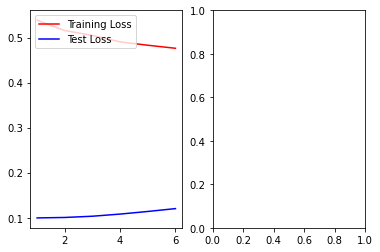

               precision    recall  f1-score   support

        toxic       0.63      0.62      0.62      6090
 severe_toxic       0.32      0.13      0.19       367
      obscene       0.69      0.58      0.63      3691
       threat       0.10      0.73      0.18       211
       insult       0.63      0.54      0.58      3427
identity_hate       0.12      0.46      0.19       712

    micro avg       0.51      0.57      0.54     14498
    macro avg       0.42      0.51      0.40     14498
 weighted avg       0.61      0.57      0.58     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 6 Train_Loss: 0.4712234708395871 Train_Accuracy: 0.034456972032785416
Epoch: 6 Test_Loss: 0.12717292404891364 Test_Accuracy: 0.9630029201507568


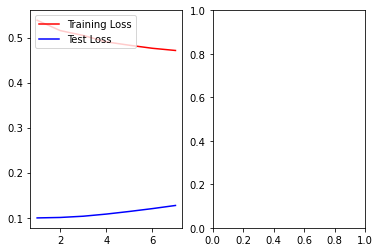

               precision    recall  f1-score   support

        toxic       0.62      0.62      0.62      6090
 severe_toxic       0.32      0.13      0.19       367
      obscene       0.69      0.58      0.63      3691
       threat       0.10      0.73      0.17       211
       insult       0.63      0.54      0.58      3427
identity_hate       0.09      0.47      0.15       712

    micro avg       0.47      0.57      0.52     14498
    macro avg       0.41      0.51      0.39     14498
 weighted avg       0.60      0.57      0.57     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 7 Train_Loss: 0.4694211469455199 Train_Accuracy: 0.03433685749769211
Epoch: 7 Test_Loss: 0.13544902388678223 Test_Accuracy: 0.9593871235847473


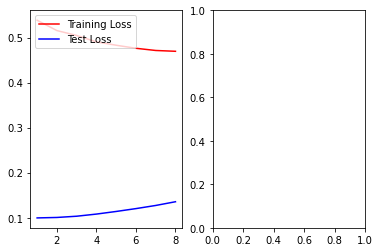

               precision    recall  f1-score   support

        toxic       0.62      0.62      0.62      6090
 severe_toxic       0.33      0.14      0.20       367
      obscene       0.69      0.58      0.63      3691
       threat       0.09      0.73      0.16       211
       insult       0.63      0.54      0.58      3427
identity_hate       0.07      0.49      0.13       712

    micro avg       0.45      0.58      0.50     14498
    macro avg       0.41      0.52      0.39     14498
 weighted avg       0.60      0.58      0.57     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 8 Train_Loss: 0.46754498237913306 Train_Accuracy: 0.03442250192165375
Epoch: 8 Test_Loss: 0.14385606201945758 Test_Accuracy: 0.9570712447166443


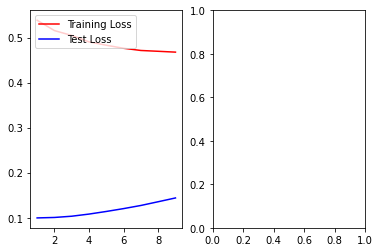

               precision    recall  f1-score   support

        toxic       0.62      0.62      0.62      6090
 severe_toxic       0.34      0.12      0.18       367
      obscene       0.70      0.58      0.63      3691
       threat       0.09      0.73      0.16       211
       insult       0.64      0.54      0.58      3427
identity_hate       0.07      0.49      0.12       712

    micro avg       0.43      0.57      0.49     14498
    macro avg       0.41      0.51      0.38     14498
 weighted avg       0.60      0.57      0.57     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 9 Train_Loss: 0.4620901210741563 Train_Accuracy: 0.0344475694000721
Epoch: 9 Test_Loss: 0.1498261238219308 Test_Accuracy: 0.9557348489761353


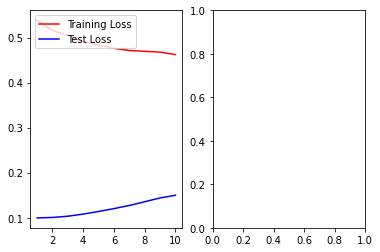

               precision    recall  f1-score   support

        toxic       0.63      0.62      0.62      6090
 severe_toxic       0.33      0.12      0.18       367
      obscene       0.70      0.58      0.63      3691
       threat       0.08      0.73      0.15       211
       insult       0.64      0.54      0.58      3427
identity_hate       0.06      0.49      0.11       712

    micro avg       0.42      0.57      0.48     14498
    macro avg       0.41      0.51      0.38     14498
 weighted avg       0.60      0.57      0.57     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 10 Train_Loss: 0.46187282827767456 Train_Accuracy: 0.034456972032785416
Epoch: 10 Test_Loss: 0.15603851172767702 Test_Accuracy: 0.95402592420578


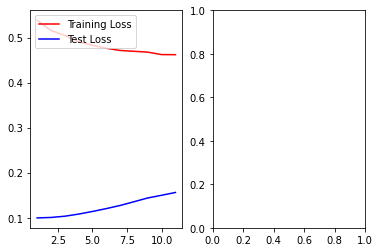

               precision    recall  f1-score   support

        toxic       0.63      0.62      0.62      6090
 severe_toxic       0.34      0.13      0.19       367
      obscene       0.70      0.58      0.63      3691
       threat       0.08      0.73      0.14       211
       insult       0.64      0.53      0.58      3427
identity_hate       0.05      0.50      0.10       712

    micro avg       0.40      0.57      0.47     14498
    macro avg       0.41      0.51      0.38     14498
 weighted avg       0.60      0.57      0.57     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 11 Train_Loss: 0.45591976696794684 Train_Accuracy: 0.03447159379720688
Epoch: 11 Test_Loss: 0.1626112060468705 Test_Accuracy: 0.9518089890480042


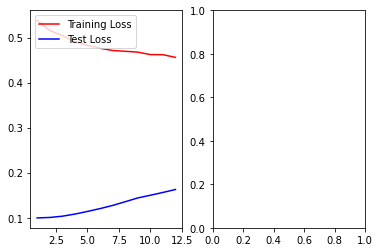

               precision    recall  f1-score   support

        toxic       0.63      0.62      0.62      6090
 severe_toxic       0.33      0.10      0.16       367
      obscene       0.70      0.57      0.63      3691
       threat       0.07      0.73      0.14       211
       insult       0.64      0.53      0.58      3427
identity_hate       0.05      0.51      0.09       712

    micro avg       0.39      0.57      0.46     14498
    macro avg       0.40      0.51      0.37     14498
 weighted avg       0.61      0.57      0.57     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 12 Train_Loss: 0.45722190222956915 Train_Accuracy: 0.0344809927046299
Epoch: 12 Test_Loss: 0.1686962494433252 Test_Accuracy: 0.9499489665031433


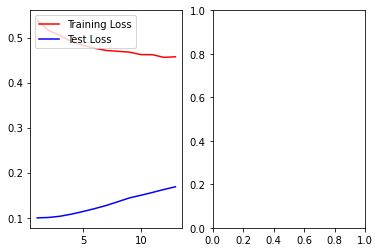

               precision    recall  f1-score   support

        toxic       0.63      0.62      0.62      6090
 severe_toxic       0.37      0.14      0.21       367
      obscene       0.70      0.57      0.63      3691
       threat       0.07      0.73      0.13       211
       insult       0.64      0.53      0.58      3427
identity_hate       0.05      0.52      0.09       712

    micro avg       0.37      0.57      0.45     14498
    macro avg       0.41      0.52      0.38     14498
 weighted avg       0.61      0.57      0.57     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 13 Train_Loss: 0.45428567311980506 Train_Accuracy: 0.0344977043569088
Epoch: 13 Test_Loss: 0.17516368594977375 Test_Accuracy: 0.9475575089454651


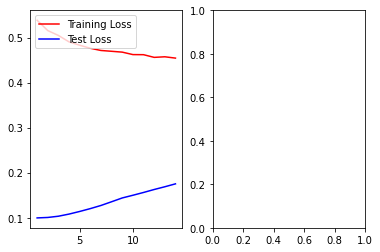

               precision    recall  f1-score   support

        toxic       0.63      0.62      0.62      6090
 severe_toxic       0.35      0.12      0.18       367
      obscene       0.71      0.57      0.63      3691
       threat       0.07      0.74      0.13       211
       insult       0.65      0.52      0.58      3427
identity_hate       0.04      0.52      0.08       712

    micro avg       0.37      0.57      0.45     14498
    macro avg       0.41      0.52      0.37     14498
 weighted avg       0.61      0.57      0.57     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 14 Train_Loss: 0.4555669277906418 Train_Accuracy: 0.034417279064655304
Epoch: 14 Test_Loss: 0.1784062488971512 Test_Accuracy: 0.9469974637031555


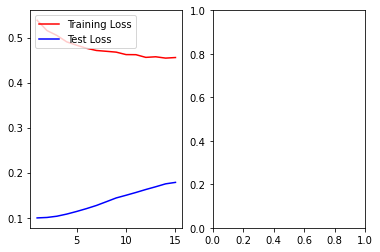

               precision    recall  f1-score   support

        toxic       0.63      0.61      0.62      6090
 severe_toxic       0.37      0.14      0.21       367
      obscene       0.71      0.57      0.63      3691
       threat       0.07      0.75      0.13       211
       insult       0.65      0.52      0.58      3427
identity_hate       0.04      0.53      0.08       712

    micro avg       0.36      0.57      0.44     14498
    macro avg       0.41      0.52      0.37     14498
 weighted avg       0.61      0.57      0.57     14498
  samples avg       0.05      0.05      0.05     14498

Epoch: 15 Train_Loss: 0.4543461352586746 Train_Accuracy: 0.03432014584541321
Epoch: 15 Test_Loss: 0.18128133911252672 Test_Accuracy: 0.946208119392395


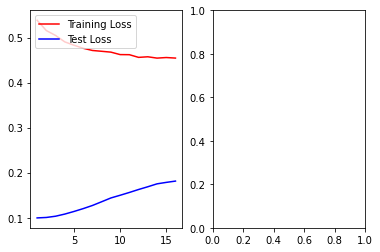

               precision    recall  f1-score   support

        toxic       0.63      0.61      0.62      6090
 severe_toxic       0.36      0.13      0.19       367
      obscene       0.72      0.57      0.63      3691
       threat       0.07      0.74      0.13       211
       insult       0.66      0.52      0.58      3427
identity_hate       0.04      0.53      0.08       712

    micro avg       0.36      0.56      0.44     14498
    macro avg       0.41      0.52      0.37     14498
 weighted avg       0.62      0.56      0.57     14498
  samples avg       0.05      0.05      0.04     14498

Epoch: 16 Train_Loss: 0.4541673416441137 Train_Accuracy: 0.034248076379299164
Epoch: 16 Test_Loss: 0.18390651698646648 Test_Accuracy: 0.9454526305198669


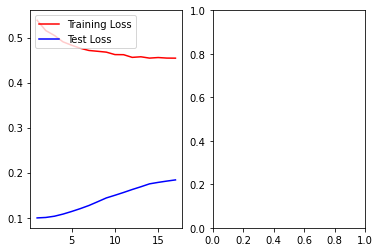

               precision    recall  f1-score   support

        toxic       0.63      0.61      0.62      6090
 severe_toxic       0.38      0.15      0.22       367
      obscene       0.72      0.56      0.63      3691
       threat       0.07      0.74      0.12       211
       insult       0.66      0.52      0.58      3427
identity_hate       0.04      0.56      0.08       712

    micro avg       0.35      0.56      0.43     14498
    macro avg       0.42      0.53      0.38     14498
 weighted avg       0.62      0.56      0.57     14498
  samples avg       0.05      0.05      0.04     14498

Epoch: 17 Train_Loss: 0.45549796521663666 Train_Accuracy: 0.03431074693799019
Epoch: 17 Test_Loss: 0.18783908056431128 Test_Accuracy: 0.9438244700431824


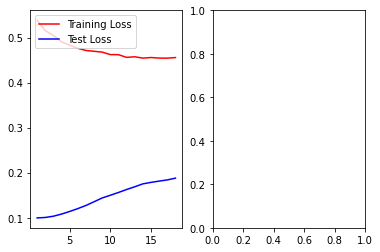

               precision    recall  f1-score   support

        toxic       0.64      0.61      0.62      6090
 severe_toxic       0.38      0.15      0.22       367
      obscene       0.72      0.56      0.63      3691
       threat       0.07      0.75      0.12       211
       insult       0.66      0.51      0.58      3427
identity_hate       0.04      0.55      0.08       712

    micro avg       0.35      0.56      0.43     14498
    macro avg       0.42      0.52      0.37     14498
 weighted avg       0.62      0.56      0.57     14498
  samples avg       0.05      0.05      0.04     14498

Epoch: 18 Train_Loss: 0.4531709998846054 Train_Accuracy: 0.034297168254852295
Epoch: 18 Test_Loss: 0.19114448390697522 Test_Accuracy: 0.9431784152984619


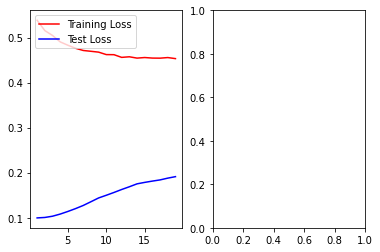

               precision    recall  f1-score   support

        toxic       0.64      0.61      0.62      6090
 severe_toxic       0.39      0.16      0.23       367
      obscene       0.72      0.56      0.63      3691
       threat       0.07      0.75      0.12       211
       insult       0.66      0.51      0.58      3427
identity_hate       0.04      0.56      0.07       712

    micro avg       0.34      0.56      0.42     14498
    macro avg       0.42      0.53      0.38     14498
 weighted avg       0.62      0.56      0.57     14498
  samples avg       0.05      0.05      0.04     14498

Epoch: 19 Train_Loss: 0.4525887248190967 Train_Accuracy: 0.03430447727441788
Epoch: 19 Test_Loss: 0.1945512994228165 Test_Accuracy: 0.942284882068634


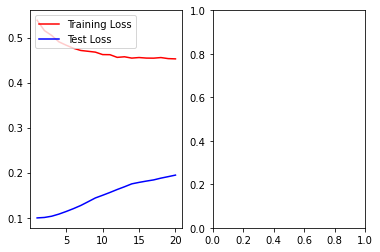

               precision    recall  f1-score   support

        toxic       0.64      0.60      0.62      6090
 severe_toxic       0.40      0.16      0.22       367
      obscene       0.73      0.56      0.63      3691
       threat       0.07      0.75      0.12       211
       insult       0.66      0.51      0.58      3427
identity_hate       0.04      0.58      0.07       712

    micro avg       0.33      0.56      0.41     14498
    macro avg       0.42      0.53      0.37     14498
 weighted avg       0.62      0.56      0.57     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 20 Train_Loss: 0.4488697079094974 Train_Accuracy: 0.03421987593173981
Epoch: 20 Test_Loss: 0.1995040782488109 Test_Accuracy: 0.9402998089790344


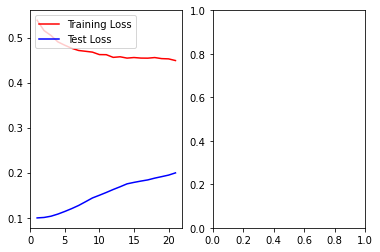

               precision    recall  f1-score   support

        toxic       0.65      0.60      0.62      6090
 severe_toxic       0.40      0.14      0.21       367
      obscene       0.73      0.55      0.63      3691
       threat       0.07      0.74      0.12       211
       insult       0.67      0.50      0.57      3427
identity_hate       0.04      0.57      0.07       712

    micro avg       0.33      0.55      0.41     14498
    macro avg       0.43      0.52      0.37     14498
 weighted avg       0.63      0.55      0.57     14498
  samples avg       0.05      0.05      0.04     14498

Epoch: 21 Train_Loss: 0.4516366408629851 Train_Accuracy: 0.03415825217962265
Epoch: 21 Test_Loss: 0.20085802039162057 Test_Accuracy: 0.9401487112045288


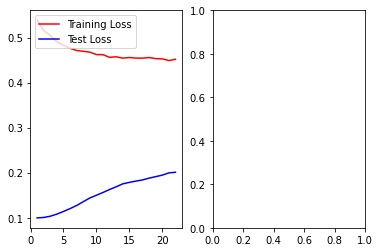

               precision    recall  f1-score   support

        toxic       0.65      0.59      0.62      6090
 severe_toxic       0.41      0.15      0.22       367
      obscene       0.73      0.55      0.63      3691
       threat       0.07      0.75      0.12       211
       insult       0.67      0.50      0.57      3427
identity_hate       0.04      0.59      0.07       712

    micro avg       0.32      0.55      0.41     14498
    macro avg       0.43      0.52      0.37     14498
 weighted avg       0.63      0.55      0.57     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 22 Train_Loss: 0.4499450109221719 Train_Accuracy: 0.034070517867803574
Epoch: 22 Test_Loss: 0.20255553966662923 Test_Accuracy: 0.939440131187439


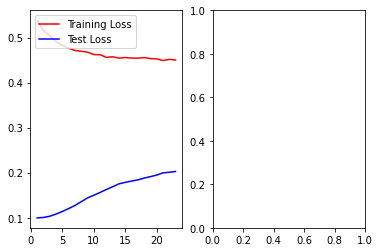

               precision    recall  f1-score   support

        toxic       0.65      0.59      0.62      6090
 severe_toxic       0.39      0.18      0.24       367
      obscene       0.73      0.55      0.63      3691
       threat       0.07      0.76      0.12       211
       insult       0.67      0.50      0.57      3427
identity_hate       0.04      0.60      0.07       712

    micro avg       0.32      0.55      0.40     14498
    macro avg       0.43      0.53      0.38     14498
 weighted avg       0.63      0.55      0.57     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 23 Train_Loss: 0.44974203543229535 Train_Accuracy: 0.03419794142246246
Epoch: 23 Test_Loss: 0.205626443761294 Test_Accuracy: 0.9383043646812439


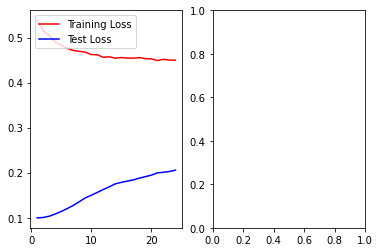

               precision    recall  f1-score   support

        toxic       0.65      0.59      0.62      6090
 severe_toxic       0.41      0.15      0.22       367
      obscene       0.74      0.54      0.63      3691
       threat       0.07      0.76      0.12       211
       insult       0.68      0.49      0.57      3427
identity_hate       0.04      0.61      0.07       712

    micro avg       0.32      0.55      0.40     14498
    macro avg       0.43      0.52      0.37     14498
 weighted avg       0.64      0.55      0.57     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 24 Train_Loss: 0.4522821835496209 Train_Accuracy: 0.03410080820322037
Epoch: 24 Test_Loss: 0.20678212204591825 Test_Accuracy: 0.9379656910896301


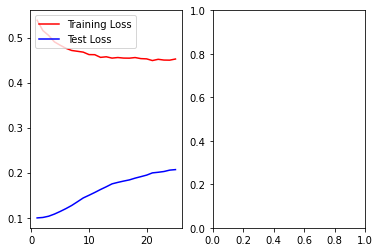

               precision    recall  f1-score   support

        toxic       0.65      0.59      0.62      6090
 severe_toxic       0.40      0.19      0.25       367
      obscene       0.74      0.54      0.63      3691
       threat       0.07      0.76      0.12       211
       insult       0.68      0.49      0.57      3427
identity_hate       0.03      0.59      0.06       712

    micro avg       0.31      0.55      0.40     14498
    macro avg       0.43      0.53      0.38     14498
 weighted avg       0.64      0.55      0.57     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 25 Train_Loss: 0.4474988891319795 Train_Accuracy: 0.03403709456324577
Epoch: 25 Test_Loss: 0.21057265052378504 Test_Accuracy: 0.9370330572128296


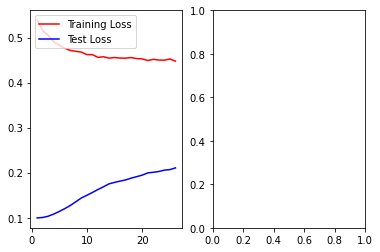

               precision    recall  f1-score   support

        toxic       0.66      0.58      0.62      6090
 severe_toxic       0.43      0.17      0.25       367
      obscene       0.74      0.54      0.62      3691
       threat       0.07      0.75      0.12       211
       insult       0.68      0.49      0.57      3427
identity_hate       0.03      0.63      0.07       712

    micro avg       0.30      0.54      0.39     14498
    macro avg       0.44      0.53      0.37     14498
 weighted avg       0.64      0.54      0.56     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 26 Train_Loss: 0.4458998062393882 Train_Accuracy: 0.03397756069898605
Epoch: 26 Test_Loss: 0.2128792146190268 Test_Accuracy: 0.935433566570282


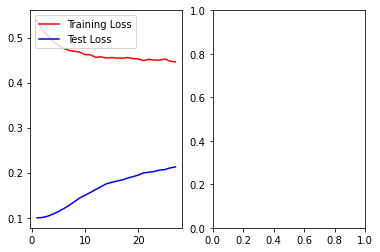

               precision    recall  f1-score   support

        toxic       0.66      0.58      0.61      6090
 severe_toxic       0.43      0.17      0.25       367
      obscene       0.75      0.53      0.62      3691
       threat       0.07      0.76      0.12       211
       insult       0.69      0.48      0.57      3427
identity_hate       0.03      0.62      0.07       712

    micro avg       0.30      0.54      0.39     14498
    macro avg       0.44      0.52      0.37     14498
 weighted avg       0.64      0.54      0.56     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 27 Train_Loss: 0.4487288838083094 Train_Accuracy: 0.03397756069898605
Epoch: 27 Test_Loss: 0.21224308323339036 Test_Accuracy: 0.9360952377319336


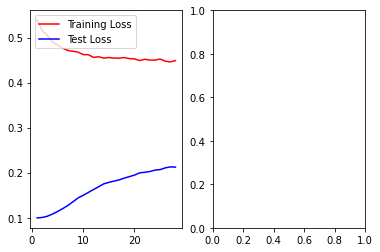

               precision    recall  f1-score   support

        toxic       0.66      0.57      0.61      6090
 severe_toxic       0.41      0.19      0.26       367
      obscene       0.75      0.53      0.62      3691
       threat       0.07      0.76      0.12       211
       insult       0.69      0.48      0.57      3427
identity_hate       0.03      0.62      0.07       712

    micro avg       0.31      0.54      0.39     14498
    macro avg       0.43      0.53      0.37     14498
 weighted avg       0.64      0.54      0.56     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 28 Train_Loss: 0.4490596042437987 Train_Accuracy: 0.03395666927099228
Epoch: 28 Test_Loss: 0.21301365427957858 Test_Accuracy: 0.93632972240448


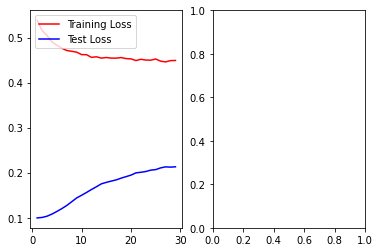

               precision    recall  f1-score   support

        toxic       0.66      0.57      0.61      6090
 severe_toxic       0.44      0.18      0.26       367
      obscene       0.75      0.53      0.62      3691
       threat       0.07      0.76      0.12       211
       insult       0.69      0.48      0.56      3427
identity_hate       0.03      0.61      0.06       712

    micro avg       0.30      0.53      0.39     14498
    macro avg       0.44      0.52      0.37     14498
 weighted avg       0.65      0.53      0.56     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 29 Train_Loss: 0.44682029431516473 Train_Accuracy: 0.03393682464957237
Epoch: 29 Test_Loss: 0.21484404159048215 Test_Accuracy: 0.9358477592468262


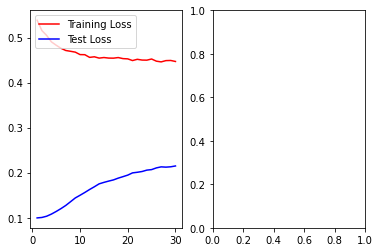

               precision    recall  f1-score   support

        toxic       0.66      0.57      0.61      6090
 severe_toxic       0.43      0.19      0.26       367
      obscene       0.75      0.53      0.62      3691
       threat       0.07      0.76      0.12       211
       insult       0.69      0.48      0.56      3427
identity_hate       0.03      0.64      0.06       712

    micro avg       0.29      0.53      0.38     14498
    macro avg       0.44      0.53      0.37     14498
 weighted avg       0.65      0.53      0.56     14498
  samples avg       0.04      0.05      0.04     14498

Epoch: 30 Train_Loss: 0.44563278555870056 Train_Accuracy: 0.03380000218749046
Epoch: 30 Test_Loss: 0.2189664563846067 Test_Accuracy: 0.9336934089660645


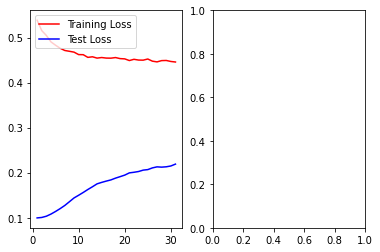

               precision    recall  f1-score   support

        toxic       0.67      0.57      0.61      6090
 severe_toxic       0.43      0.19      0.26       367
      obscene       0.75      0.53      0.62      3691
       threat       0.06      0.76      0.12       211
       insult       0.69      0.48      0.56      3427
identity_hate       0.03      0.64      0.06       712

    micro avg       0.29      0.53      0.38     14498
    macro avg       0.44      0.53      0.37     14498
 weighted avg       0.65      0.53      0.56     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 31 Train_Loss: 0.44402961297468707 Train_Accuracy: 0.03396189212799072
Epoch: 31 Test_Loss: 0.22068343861181228 Test_Accuracy: 0.9332844018936157


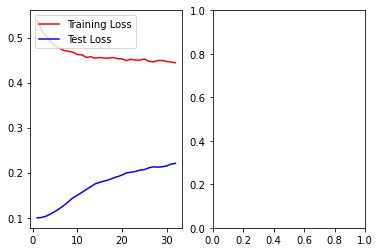

               precision    recall  f1-score   support

        toxic       0.67      0.56      0.61      6090
 severe_toxic       0.44      0.15      0.23       367
      obscene       0.76      0.52      0.62      3691
       threat       0.06      0.76      0.12       211
       insult       0.70      0.47      0.56      3427
identity_hate       0.03      0.66      0.06       712

    micro avg       0.28      0.53      0.37     14498
    macro avg       0.44      0.52      0.37     14498
 weighted avg       0.65      0.53      0.56     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 32 Train_Loss: 0.4451776607470079 Train_Accuracy: 0.03382088989019394
Epoch: 32 Test_Loss: 0.22410778424453215 Test_Accuracy: 0.9314790964126587


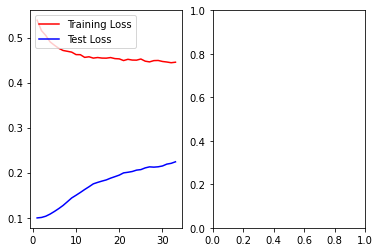

               precision    recall  f1-score   support

        toxic       0.67      0.56      0.61      6090
 severe_toxic       0.45      0.17      0.25       367
      obscene       0.76      0.52      0.62      3691
       threat       0.06      0.76      0.12       211
       insult       0.70      0.47      0.56      3427
identity_hate       0.03      0.65      0.06       712

    micro avg       0.29      0.52      0.37     14498
    macro avg       0.45      0.52      0.37     14498
 weighted avg       0.66      0.52      0.56     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 33 Train_Loss: 0.4471266201951287 Train_Accuracy: 0.03384386748075485
Epoch: 33 Test_Loss: 0.22232251756829643 Test_Accuracy: 0.9329223036766052


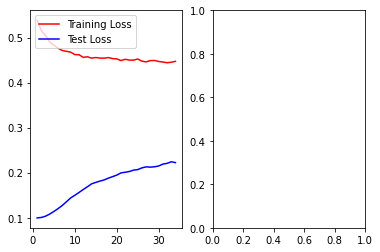

               precision    recall  f1-score   support

        toxic       0.67      0.56      0.61      6090
 severe_toxic       0.41      0.19      0.26       367
      obscene       0.76      0.52      0.62      3691
       threat       0.06      0.76      0.11       211
       insult       0.70      0.47      0.56      3427
identity_hate       0.03      0.65      0.06       712

    micro avg       0.28      0.52      0.36     14498
    macro avg       0.44      0.52      0.37     14498
 weighted avg       0.66      0.52      0.56     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 34 Train_Loss: 0.44518664479255676 Train_Accuracy: 0.03378851339221001
Epoch: 34 Test_Loss: 0.22811014453570047 Test_Accuracy: 0.9304500818252563


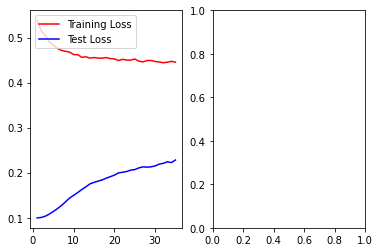

               precision    recall  f1-score   support

        toxic       0.68      0.55      0.61      6090
 severe_toxic       0.42      0.19      0.26       367
      obscene       0.76      0.52      0.62      3691
       threat       0.06      0.76      0.11       211
       insult       0.70      0.47      0.56      3427
identity_hate       0.03      0.66      0.06       712

    micro avg       0.28      0.52      0.36     14498
    macro avg       0.44      0.52      0.37     14498
 weighted avg       0.66      0.52      0.56     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 35 Train_Loss: 0.44438105686144397 Train_Accuracy: 0.03374255448579788
Epoch: 35 Test_Loss: 0.22938159808435074 Test_Accuracy: 0.9300072193145752


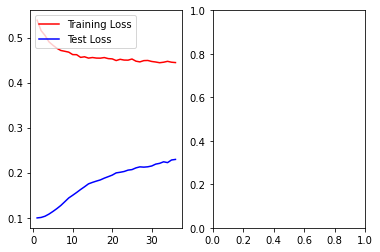

               precision    recall  f1-score   support

        toxic       0.68      0.55      0.61      6090
 severe_toxic       0.45      0.17      0.25       367
      obscene       0.77      0.51      0.61      3691
       threat       0.06      0.76      0.12       211
       insult       0.71      0.46      0.56      3427
identity_hate       0.03      0.67      0.06       712

    micro avg       0.27      0.52      0.36     14498
    macro avg       0.45      0.52      0.37     14498
 weighted avg       0.66      0.52      0.55     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 36 Train_Loss: 0.44487823004072363 Train_Accuracy: 0.033663176000118256
Epoch: 36 Test_Loss: 0.2302298992057967 Test_Accuracy: 0.9296295046806335


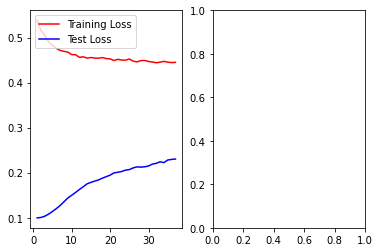

               precision    recall  f1-score   support

        toxic       0.68      0.54      0.61      6090
 severe_toxic       0.46      0.17      0.25       367
      obscene       0.77      0.51      0.61      3691
       threat       0.06      0.76      0.11       211
       insult       0.71      0.46      0.56      3427
identity_hate       0.03      0.66      0.06       712

    micro avg       0.27      0.52      0.36     14498
    macro avg       0.45      0.52      0.37     14498
 weighted avg       0.67      0.52      0.55     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 37 Train_Loss: 0.44409884918819775 Train_Accuracy: 0.03352217376232147
Epoch: 37 Test_Loss: 0.2302721602017762 Test_Accuracy: 0.9302546977996826


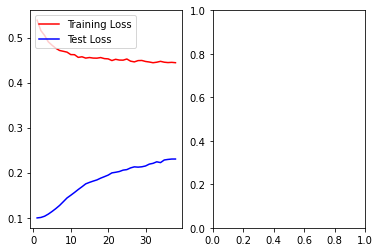

               precision    recall  f1-score   support

        toxic       0.69      0.54      0.61      6090
 severe_toxic       0.44      0.18      0.25       367
      obscene       0.77      0.51      0.61      3691
       threat       0.06      0.77      0.11       211
       insult       0.71      0.46      0.56      3427
identity_hate       0.03      0.64      0.06       712

    micro avg       0.27      0.51      0.35     14498
    macro avg       0.45      0.52      0.37     14498
 weighted avg       0.67      0.51      0.55     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 38 Train_Loss: 0.4460380551489917 Train_Accuracy: 0.03351695090532303
Epoch: 38 Test_Loss: 0.233023787863919 Test_Accuracy: 0.9294002652168274


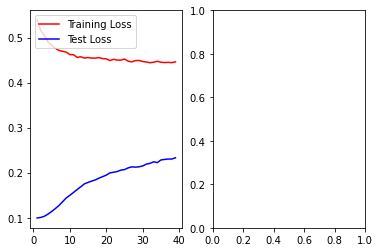

               precision    recall  f1-score   support

        toxic       0.69      0.54      0.61      6090
 severe_toxic       0.43      0.18      0.25       367
      obscene       0.77      0.51      0.61      3691
       threat       0.06      0.77      0.11       211
       insult       0.71      0.46      0.56      3427
identity_hate       0.03      0.67      0.06       712

    micro avg       0.26      0.51      0.35     14498
    macro avg       0.45      0.52      0.37     14498
 weighted avg       0.67      0.51      0.55     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 39 Train_Loss: 0.4415738447145982 Train_Accuracy: 0.033639151602983475
Epoch: 39 Test_Loss: 0.23653466405112886 Test_Accuracy: 0.9277017712593079


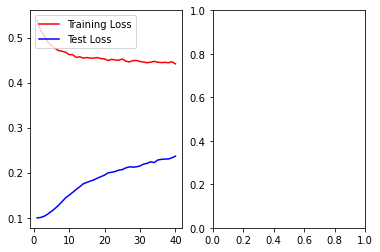

               precision    recall  f1-score   support

        toxic       0.69      0.53      0.60      6090
 severe_toxic       0.47      0.16      0.24       367
      obscene       0.78      0.50      0.61      3691
       threat       0.06      0.76      0.11       211
       insult       0.72      0.45      0.56      3427
identity_hate       0.03      0.67      0.05       712

    micro avg       0.26      0.51      0.34     14498
    macro avg       0.46      0.51      0.36     14498
 weighted avg       0.67      0.51      0.55     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 40 Train_Loss: 0.44334571063518524 Train_Accuracy: 0.033460550010204315
Epoch: 40 Test_Loss: 0.23993177980673117 Test_Accuracy: 0.9258104562759399


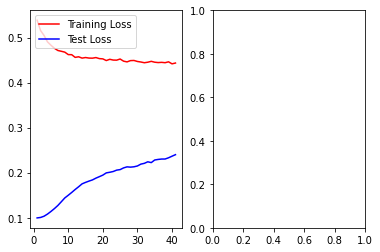

               precision    recall  f1-score   support

        toxic       0.70      0.53      0.60      6090
 severe_toxic       0.45      0.17      0.24       367
      obscene       0.78      0.50      0.61      3691
       threat       0.06      0.76      0.12       211
       insult       0.72      0.45      0.56      3427
identity_hate       0.03      0.66      0.05       712

    micro avg       0.26      0.50      0.34     14498
    macro avg       0.46      0.51      0.36     14498
 weighted avg       0.68      0.50      0.55     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 41 Train_Loss: 0.4421553151174025 Train_Accuracy: 0.03348039463162422
Epoch: 41 Test_Loss: 0.23897545226936132 Test_Accuracy: 0.9261413216590881


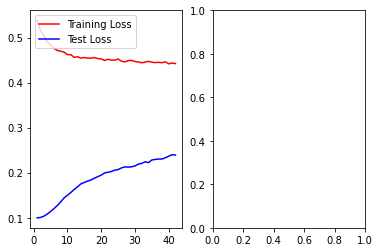

               precision    recall  f1-score   support

        toxic       0.70      0.52      0.60      6090
 severe_toxic       0.45      0.17      0.25       367
      obscene       0.78      0.50      0.61      3691
       threat       0.06      0.77      0.11       211
       insult       0.72      0.45      0.56      3427
identity_hate       0.03      0.66      0.05       712

    micro avg       0.25      0.50      0.34     14498
    macro avg       0.46      0.51      0.36     14498
 weighted avg       0.68      0.50      0.55     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 42 Train_Loss: 0.4426103261384097 Train_Accuracy: 0.03340832516551018
Epoch: 42 Test_Loss: 0.2418681669756363 Test_Accuracy: 0.9250081181526184


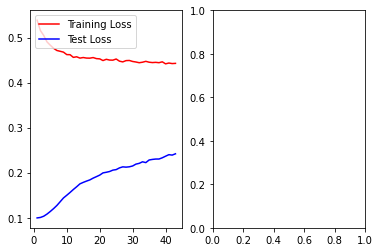

               precision    recall  f1-score   support

        toxic       0.70      0.52      0.60      6090
 severe_toxic       0.45      0.18      0.25       367
      obscene       0.78      0.50      0.61      3691
       threat       0.06      0.77      0.11       211
       insult       0.72      0.45      0.55      3427
identity_hate       0.03      0.66      0.05       712

    micro avg       0.25      0.50      0.33     14498
    macro avg       0.46      0.51      0.36     14498
 weighted avg       0.68      0.50      0.55     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 43 Train_Loss: 0.44332085007970984 Train_Accuracy: 0.03340832516551018
Epoch: 43 Test_Loss: 0.24296871031242642 Test_Accuracy: 0.9249820709228516


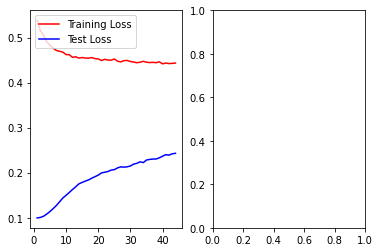

               precision    recall  f1-score   support

        toxic       0.70      0.51      0.59      6090
 severe_toxic       0.47      0.16      0.24       367
      obscene       0.79      0.49      0.61      3691
       threat       0.06      0.77      0.11       211
       insult       0.73      0.44      0.55      3427
identity_hate       0.03      0.65      0.05       712

    micro avg       0.25      0.49      0.33     14498
    macro avg       0.46      0.51      0.36     14498
 weighted avg       0.68      0.49      0.54     14498
  samples avg       0.04      0.04      0.04     14498

Epoch: 44 Train_Loss: 0.4429353949698535 Train_Accuracy: 0.033232856541872025
Epoch: 44 Test_Loss: 0.24304321286131125 Test_Accuracy: 0.9253493547439575


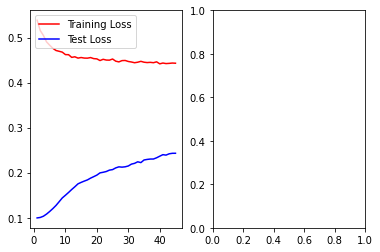

In [ ]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
torch.backends.cudnn.benchmark = True
epochs = 3500
training_losses_2 = [ None for i in range(epochs)]
test_losses_2 = [ None for i in range(epochs)]
epoch_count_2 = [i for i in range(1, epochs+1)]

accuracys_2 = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    correct_predictions = 0
    for batch_id, batch in enumerate(train_dataloader_2):

        ids = batch['indices'].to(device)
        #print('ids: ', ids.shape)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        # print('preds: ', preds.shape)
        for row in range(len(preds)):
            outputs[row][0] = labels[row][0]
            outputs[row][2] = labels[row][2]
            outputs[row][4] = labels[row][4]
            #print(preds[row][0])
        loss = loss_fn(outputs, labels)
        #print('loss: ', loss)

        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        # if batch_id % 100 == 0:
            # print('Epoch: {} Batch: {} Loss: {}'.format(e, batch_id, loss.item()))
            #print(loss.grad_fn)

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses_2[e] = epoch_loss
    train_accuracy = correct_predictions/(len(df)*6)


    ## Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        predictions_store = []
        labels_store = []

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                predictions_store.append(preds[i])
                labels_store.append(labels[i])

        # print(pred_counter, label_counter)
        test_loss = np.mean(test_loss)
        accuracy = test_correct_predictions/(len(test_dataset)*6)
        test_losses_2[e] = test_loss

        rp = classification_report(labels_store, predictions_store, target_names=classes)
        print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, accuracy))

        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count_2, training_losses_2, 'r', label='Training Loss')
        ax1.plot(epoch_count_2, test_losses_2, 'b', label='Test Loss')
        ax1.legend(loc="upper left")

        plt.show()


